In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
from webweb import Web
import os
import seaborn as sns
from BOCC import BOCC, load_clusters
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import typing
import matplotlib.patches as mpatches
from upsetplot import from_memberships
from upsetplot import plot
import random
import pickle


std_fontsize = 12

/Users/michael/miniconda3/envs/bocc/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G22 = nx.read_edgelist('../Edgelists/String_HPO_2022.phenotypic_branch.edgelist.txt')

def remove_trivial_coms(coms):
    keepers = []
    for c in coms:
        if len(c.members) > 2 and len(c.get_genes()) > 0 and len(c.get_genes()) != len(c.members):
            keepers.append(c)
    return keepers

g_subcoms = load_clusters('../SubComs/2021/paris.greedy.2021.coms.txt')
w_subcoms = load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
i_subcoms = load_clusters('../SubComs/2021/paris.infomap.2021.coms.txt')
c_subcoms = load_clusters('../SubComs/2021/paris.cesna.2021.coms.txt')

In [3]:
def get_possible_pairs_from_com(coms,G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = []
    for com in coms:
        pairs.append(set())
        genes = [x for x in com.members if 'HP:' not in x]
        hpos = [x for x in com.members if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
        for g in genes:
            for h in hpos:
                p=[g,h]
                # check if p in in G
                if G.has_edge(p[0],p[1]):
                    continue
                p.sort()
                pairs[-1].add(str(p))
    return pairs

def get_possible_pairs_from_com_non_bocc(com,G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = set()
    genes = [x for x in com if 'HP:' not in x]
    hpos = [x for x in com if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
    for g in genes:
        for h in hpos:
            p=[g,h]
            # check if p in in G
            if G.has_edge(p[0],p[1]):
                continue
            p.sort()
            pairs.add(str(p))
    return pairs

def load_new_edges(el,G):
    pairs = set()
    for line in open(el,'r'):
        row = line.strip().split('\t')
        row.sort()
        if G.has_edge(row[0],row[1]):
            continue
        pairs.add(str(row))
    return pairs

# load new edges but shuffle them
def load_new_edges_shuffled(el, seed=None):
    pairs = set()
    genes = []
    hpos = []
    rows = 0
    for line in open(el,'r'):
        row = line.strip().split('\t')
        # add the HPO term to the list of HPO terms
        if 'HP:' in row[0]:
            hpos.append(row[0])
            genes.append(row[1])
        else:
            genes.append(row[0])
            hpos.append(row[1])
        rows += 1
    # shuffle the genes and hpos
    np.random.seed(seed)
    np.random.shuffle(genes)
    np.random.shuffle(hpos)
    # create the pairs
    for i in range(len(genes)):
        p = [genes[i],hpos[i]]
        p.sort()
        pairs.add(str(p))
    return pairs
    

def rediscover(pairs, el_pairs):
    # find the intersection
    results = []
    for com_pairs in pairs:
        results.append(len(com_pairs.intersection(el_pairs)))
    return results

In [4]:
s0 = load_new_edges_shuffled(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt',seed=0)
s1 = load_new_edges_shuffled(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt',seed=1)

In [5]:
def edge_shuffle_pvalue(current_subcoms, current_G, future_el, name, n=1000):
    # get the possible pairs
    com_pairs = get_possible_pairs_from_com(current_subcoms,current_G)
    print(name,len(com_pairs))

    # load the new edges
    el_pairs = load_new_edges(el=future_el, G=current_G)
    # print('2020',len(el_pairs))

    # score the cluster's rediscoveries
    rediscoveries = rediscover(com_pairs, el_pairs)
    # print('Greedy',len(rediscoveries))

    # do 10 shuffled rediscoveries
    shuffled_rediscoveries = []
    for i in range(1000):
        s = load_new_edges_shuffled(el=future_el,seed=i)
        shuffled_rediscoveries.append(rediscover(com_pairs, s))

    # compare the rediscoveries to the shuffled rediscoveries
    p_values = []
    com_names = []
    for i in range(len(rediscoveries)):
        if i % 100 == 0:
            print(name,i)
        com_names.append(name+current_subcoms[i].name)
        this_coms_shuffled_rediscoveries = [x[i] for x in shuffled_rediscoveries]
        # empirical p-value for number of times rediscovery is greater than or equal to the shuffled rediscovery
        p = 1 - (sum([1 for x in this_coms_shuffled_rediscoveries if rediscoveries[i] >= x])/len(this_coms_shuffled_rediscoveries))
        p_values.append(p)
    return pd.DataFrame({'cluster_id':com_names, 'shuffled_pvalue':p_values})
greedy19df = edge_shuffle_pvalue(g_subcoms, G19, '../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', 'paris.greedy.2019:')
print('Greedy',greedy19df.shape)
walktrap19df = edge_shuffle_pvalue(w_subcoms, G19, '../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', 'paris.walktrap.2019:')
print('Walktrap',walktrap19df.shape)
infomap19df = edge_shuffle_pvalue(i_subcoms, G19, '../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', 'paris.infomap.2019:')
print('Infomap',infomap19df.shape)
cesna19df = edge_shuffle_pvalue(c_subcoms, G19, '../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', 'paris.cesna.2019:')
print('Cesna',cesna19df.shape)

paris.greedy.2019: 1218
paris.greedy.2019: 0
paris.greedy.2019: 100
paris.greedy.2019: 200
paris.greedy.2019: 300
paris.greedy.2019: 400
paris.greedy.2019: 500
paris.greedy.2019: 600
paris.greedy.2019: 700
paris.greedy.2019: 800
paris.greedy.2019: 900
paris.greedy.2019: 1000
paris.greedy.2019: 1100
paris.greedy.2019: 1200
Greedy (1218, 2)
paris.walktrap.2019: 2301
paris.walktrap.2019: 0
paris.walktrap.2019: 100
paris.walktrap.2019: 200
paris.walktrap.2019: 300
paris.walktrap.2019: 400
paris.walktrap.2019: 500
paris.walktrap.2019: 600
paris.walktrap.2019: 700
paris.walktrap.2019: 800
paris.walktrap.2019: 900
paris.walktrap.2019: 1000
paris.walktrap.2019: 1100
paris.walktrap.2019: 1200
paris.walktrap.2019: 1300
paris.walktrap.2019: 1400
paris.walktrap.2019: 1500
paris.walktrap.2019: 1600
paris.walktrap.2019: 1700
paris.walktrap.2019: 1800
paris.walktrap.2019: 1900
paris.walktrap.2019: 2000
paris.walktrap.2019: 2100
paris.walktrap.2019: 2200
paris.walktrap.2019: 2300
Walktrap (2301, 2)
pa

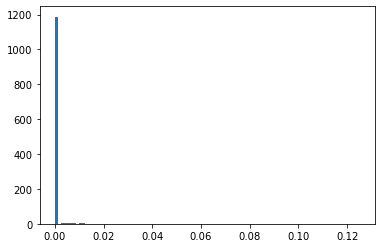

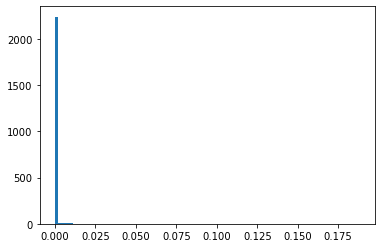

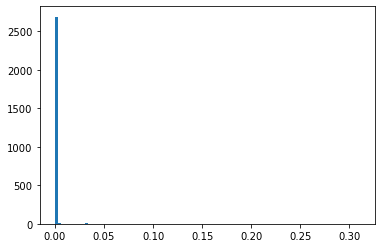

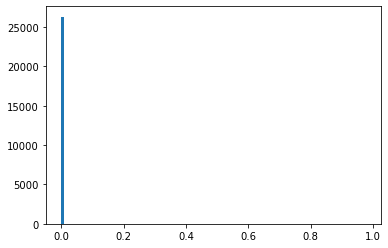

In [6]:
# save the results
greedy19df.to_csv('../RandomShufflePValues/paris.greedy.2019.shuffled_pvalues.txt',sep='\t',index=False)
walktrap19df.to_csv('../RandomShufflePValues/paris.walktrap.2019.shuffled_pvalues.txt',sep='\t',index=False)
infomap19df.to_csv('../RandomShufflePValues/paris.infomap.2019.shuffled_pvalues.txt',sep='\t',index=False)
cesna19df.to_csv('../RandomShufflePValues/paris.cesna.2019.shuffled_pvalues.txt',sep='\t',index=False)

# plot histograms of the p-values
plt.hist(greedy19df['shuffled_pvalue'],bins=100)
plt.show()
plt.hist(walktrap19df['shuffled_pvalue'],bins=100)
plt.show()
plt.hist(infomap19df['shuffled_pvalue'],bins=100)
plt.show()
plt.hist(cesna19df['shuffled_pvalue'],bins=100)
plt.show()

In [10]:
cluster_scores = {}
first= True
for line in open('../AnyNewEdgeCountSnowballedCleanedSplit100BOCCResultsCombinedFixed/2021/paris.greedy.2021.bocc_res.tsv','r'):
    row = line.strip().split('\t')
    if first:
        first = False
        print(row[35])
        continue
#     print(line)
    cluster_scores['paris.greedy.2021:{}'.format(row[0])] = float(row[35])
print(list(cluster_scores.keys())[0])

sub_com_names = ['paris.greedy.2021:{}'.format(x.name) for x in g_subcoms]
print(sub_com_names)

snowballing_pvalue
paris.greedy.2021:42
['paris.greedy.2021:0', 'paris.greedy.2021:1', 'paris.greedy.2021:2', 'paris.greedy.2021:3', 'paris.greedy.2021:4', 'paris.greedy.2021:5', 'paris.greedy.2021:6', 'paris.greedy.2021:7', 'paris.greedy.2021:8', 'paris.greedy.2021:9', 'paris.greedy.2021:10', 'paris.greedy.2021:11', 'paris.greedy.2021:12', 'paris.greedy.2021:13', 'paris.greedy.2021:14', 'paris.greedy.2021:15', 'paris.greedy.2021:16', 'paris.greedy.2021:17', 'paris.greedy.2021:18', 'paris.greedy.2021:19', 'paris.greedy.2021:20', 'paris.greedy.2021:21', 'paris.greedy.2021:22', 'paris.greedy.2021:23', 'paris.greedy.2021:24', 'paris.greedy.2021:25', 'paris.greedy.2021:26', 'paris.greedy.2021:27', 'paris.greedy.2021:28', 'paris.greedy.2021:29', 'paris.greedy.2021:30', 'paris.greedy.2021:31', 'paris.greedy.2021:32', 'paris.greedy.2021:33', 'paris.greedy.2021:34', 'paris.greedy.2021:35', 'paris.greedy.2021:36', 'paris.greedy.2021:37', 'paris.greedy.2021:38', 'paris.greedy.2021:39', 'paris.gr

# Random Clusters


In [12]:
# for each cluster, get the number of members
random.seed(0)
# check if cluster_rediscoveries.pickle exists
if os.path.exists('cluster_rediscoveries.pickle'):
    # load the pickle file
    with open('cluster_rediscoveries.pickle','rb') as f:
        cluster_rediscoveries = pickle.load(f)
else:
    cluster_rediscoveries = []
    for j in range(1000):
        if j % 100 == 0:
            print(j)
        cluster_rediscoveries.append([])
        for i in range(len(g_subcoms)):
            # print('Cluster',i)
            first_resample = True
            # print(i)
            size = len(g_subcoms[i].members)
            if size < 3:
                cluster_rediscoveries[-1].append(rediscoveries)
                continue
            # from G19 pick size number of nodes at random, if there nodes do not have a phenotype, then re pick
            heterozygous = False
            while not heterozygous:
                # the line above but make sure it samples without replacement
                nodes = random.choices(list(G19.nodes),k=size)
                has_hpo = any([ 'HP:' in x for x in nodes])
                has_gene = any([ 'HP:' not in x for x in nodes])
                heterozygous = has_hpo and has_gene
            random_pairs = get_possible_pairs_from_com_non_bocc(nodes, G19)
            rediscoveries = len(random_pairs.intersection(el_pairs))
            cluster_rediscoveries[j].append(rediscoveries)

    for i in range(len(cluster_rediscoveries)):
        print(i, len(cluster_rediscoveries[i]))
    with open('cluster_rediscoveries.pickle','wb') as f:
        pickle.dump(cluster_rediscoveries,f)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


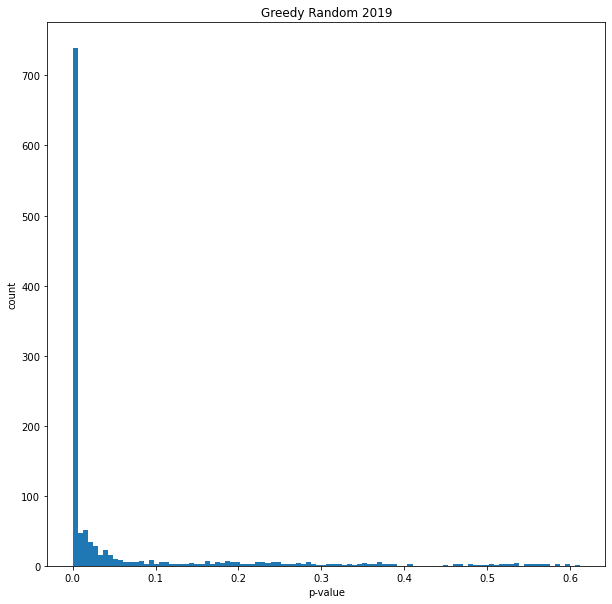

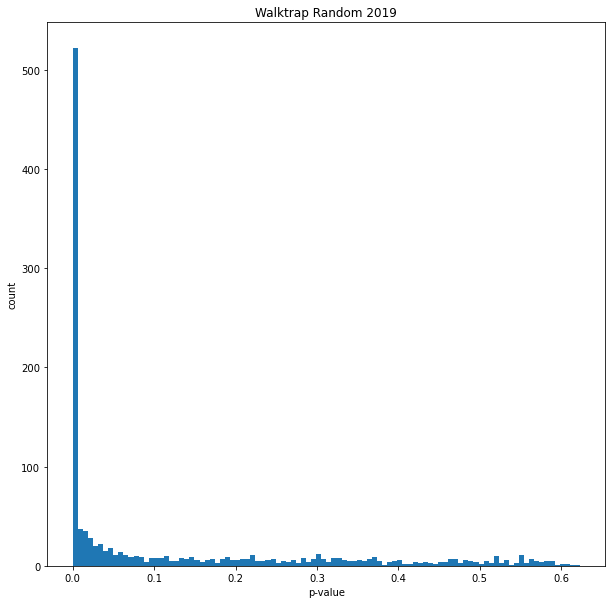

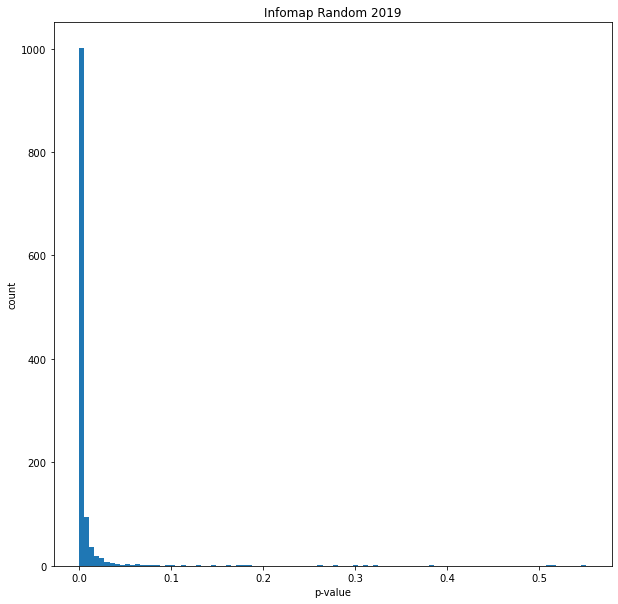

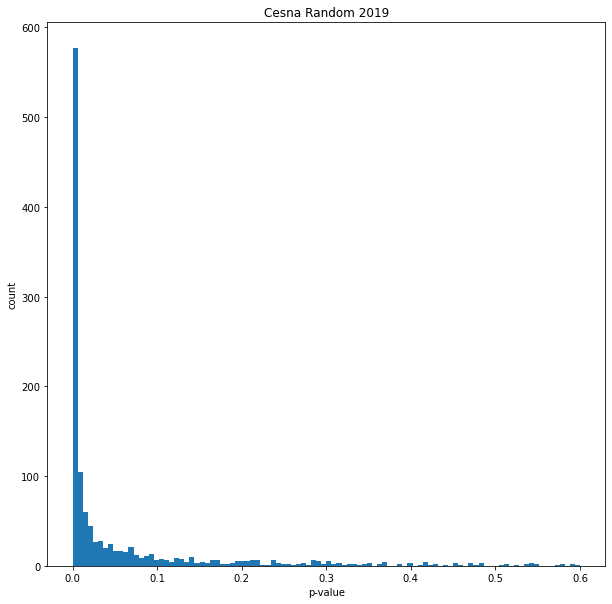

In [13]:
random.seed(0)
def random_clusters(G,current_coms,future_el,name):
    future_pairs = load_new_edges(el=future_el, G=G)
    cluster_rediscoveries = []
    for j in range(1000):
        if j % 100 == 0:
            print(j)
        cluster_rediscoveries.append([])
        for i in range(len(current_coms)):
            # print('Cluster',i)
            first_resample = True
            # print(i)
            size = len(current_coms[i].members)
            if size < 3:
                cluster_rediscoveries[-1].append(-1)
                continue
            # from G19 pick size number of nodes at random, if there nodes do not have a phenotype, then re pick
            heterozygous = False
            while not heterozygous:
                # the line above but make sure it samples without replacement
                nodes = random.choices(list(G.nodes),k=size)
                has_hpo = any([ 'HP:' in x for x in nodes])
                has_gene = any([ 'HP:' not in x for x in nodes])
                heterozygous = has_hpo and has_gene
            random_pairs = get_possible_pairs_from_com_non_bocc(nodes, G19)
            tmp_rediscoveries = len(random_pairs.intersection(future_pairs))
            cluster_rediscoveries[j].append(tmp_rediscoveries)

    rediscovery_p_values = []
    for i in range(len(rediscoveries)):
        this_coms_cluster_rediscoveries = [x[i] for x in cluster_rediscoveries]
        # empirical p-value for number of times rediscovery is greater than or equal to the shuffled rediscovery
        p = 1 - (sum([1 for x in this_coms_cluster_rediscoveries if rediscoveries[i] >= x])/len(this_coms_cluster_rediscoveries))
        rediscovery_p_values.append(p)
    
    sub_com_names = [name + str(x.name) for x in current_coms]
    p_values_filtered_random_null = []
    sub_com_names_filtered_random_null = []
    for i in range(len(rediscovery_p_values)):
        p_values_filtered_random_null.append(rediscovery_p_values[i])
        sub_com_names_filtered_random_null.append(sub_com_names[i])
    # make a dataframe of the rediscovery p-values and cluster scores and cluster names
    random_null_df = pd.DataFrame({'random_com_p-value':p_values_filtered_random_null,
                                'cluster_name':sub_com_names_filtered_random_null})
    return random_null_df

greedy_random_19_df = random_clusters(G19,g_subcoms,'../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt','paris.greedy.2019:')
walktrap_random_19_df = random_clusters(G19,w_subcoms,'../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt','paris.walktrap.2019:')
infomap_random_19_df = random_clusters(G19,i_subcoms,'../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt','paris.infomap.2019:')
cesna_random_19_df = random_clusters(G19,c_subcoms,'../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt','paris.cesna.2019:')

# save the dataframes
greedy_random_19_df.to_csv('../RandomClustersPValues/greedy_random_19_df.csv')
walktrap_random_19_df.to_csv('../RandomClustersPValues/walktrap_random_19_df.csv')
infomap_random_19_df.to_csv('../RandomClustersPValues/infomap_random_19_df.csv')
cesna_random_19_df.to_csv('../RandomClustersPValues/cesna_random_19_df.csv')

# plot the p-values as a histogram
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.hist(greedy_random_19_df['random_com_p-value'],bins=100)
ax.set_title('Greedy Random 2019')
ax.set_xlabel('p-value')
ax.set_ylabel('count')
plt.show()

      random_com_p-value            cluster_name
0                  0.002     paris.greedy.2019:0
1                  0.000     paris.greedy.2019:1
2                  0.002     paris.greedy.2019:2
3                  0.000     paris.greedy.2019:3
4                  0.003     paris.greedy.2019:4
...                  ...                     ...
1213               0.000  paris.greedy.2019:1213
1214               0.000  paris.greedy.2019:1214
1215               0.000  paris.greedy.2019:1215
1216               0.002  paris.greedy.2019:1216
1217               0.000  paris.greedy.2019:1217

[1218 rows x 2 columns]
snowballing p = 1: 0.7994722955145118
edge shuffle p = 0: 0.964696223316913
random clusters p = 0: 0.4876847290640394


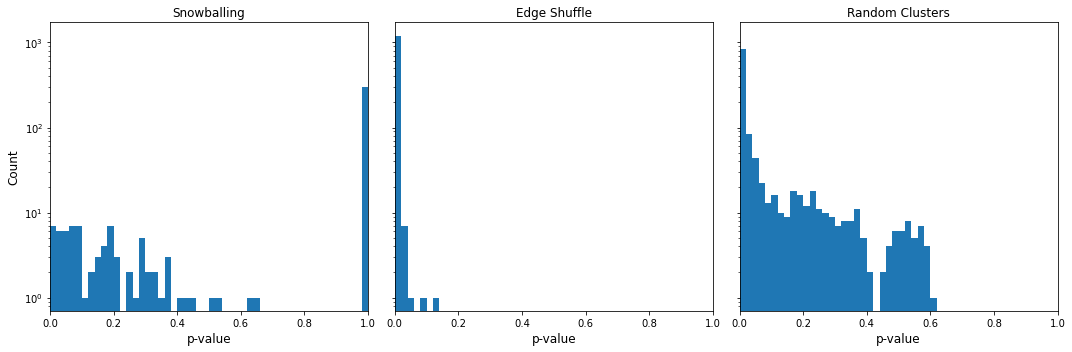

In [33]:
# plot 3 historgrams of snowballing p-values, edge shuffle and random cluster p-values

# print(random_null_df)
# print(greedy19df)
print(greedy_random_19_df)

snowballing_col = 'p-value'
edge_shuffle_col = 'shuffled_pvalue'
rand_clsuter_col = 'cluster_score'

fig, ax = plt.subplots(1,3,sharey=True)
fig.set_size_inches(15,5)

ax[0].hist(cluster_scores.values(),bins=50,range=[0,1])
ax[1].hist(greedy19df['shuffled_pvalue'],bins=50,range=[0,1])
ax[2].hist(greedy_random_19_df['random_com_p-value'],bins=50,range=[0,1])
ax[0].set_xlabel('p-value',fontsize=std_fontsize)
ax[1].set_xlabel('p-value',fontsize=std_fontsize)
ax[2].set_xlabel('p-value',fontsize=std_fontsize)
ax[0].set_ylabel('Count',fontsize=std_fontsize)
ax[0].set_title('Snowballing',fontsize=std_fontsize)
ax[1].set_title('Edge Shuffle',fontsize=std_fontsize)
ax[2].set_title('Random Clusters',fontsize=std_fontsize)
ax[0].set_yscale('log')
ax[0].set_xlim([0,1])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,1])

plt.tight_layout()
plt.savefig('../PublicationFigures/null_model_hists.png',dpi=300)

# what % of cluster_scores.values() is p = 1
print('snowballing p = 1: ' + str(sum([1 for x in cluster_scores.values() if x == 1])/len(cluster_scores.values())))

# what % of greedy19df['shuffled_pvalue'] is p = 0
print('edge shuffle p = 0: ' + str(sum([1 for x in greedy19df['shuffled_pvalue'] if x == 0])/len(greedy19df['shuffled_pvalue'])))
# what % of greedy_random_19_df['random_com_p-value'] is p = 0
print('random clusters p = 0: ' + str(sum([1 for x in greedy_random_19_df['random_com_p-value'] if x == 0])/len(greedy_random_19_df['random_com_p-value'])))